In [1]:
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import scipy.optimize as opt
from multigauss import multigauss
from scipy.optimize import curve_fit

In [2]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# Dáta, kovariancia, vlastné hodnoty

In [3]:
datasets = ["3432B",
            "3813A",
            "3816A",
            "3832A"]
#
data = np.zeros((0, 105))
for ds in datasets:
    sel = np.load(f"data/selected/sel_voxels_{ds}.npy")
    data = np.concatenate([data, sel])
# #
# data = np.load("data/BigBrain/syn_signal.npy").reshape((74 * 57 * 65, 105))
# data = np.load("data/syn_7comp.npy")
# data = np.array([x[14:] for x in data])
print(data.shape)

(195525, 105)


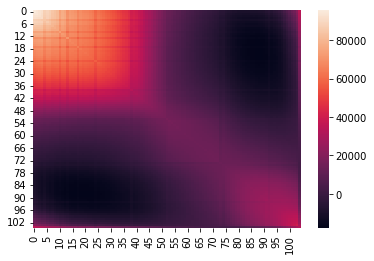

In [4]:
cov_m = np.cov(data.T)

sn.heatmap(cov_m)
plt.savefig("hm")
plt.show()

In [5]:
print(np.min(cov_m))

-17720.335193497678


In [6]:
e_val, e_vec = np.linalg.eig(cov_m)
print(np.argsort(-1 * e_val[:10]))


[0 1 2 3 4 5 6 7 8 9]


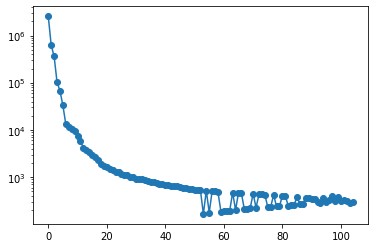

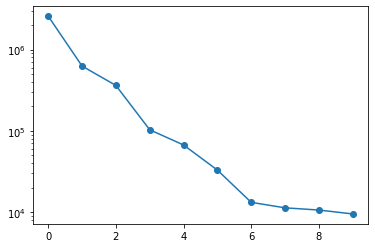

In [7]:
plt.plot(e_val, marker='o')
plt.yscale("log")
plt.show()
plt.yscale("log")
plt.plot(e_val[:10], marker='o')
plt.show()

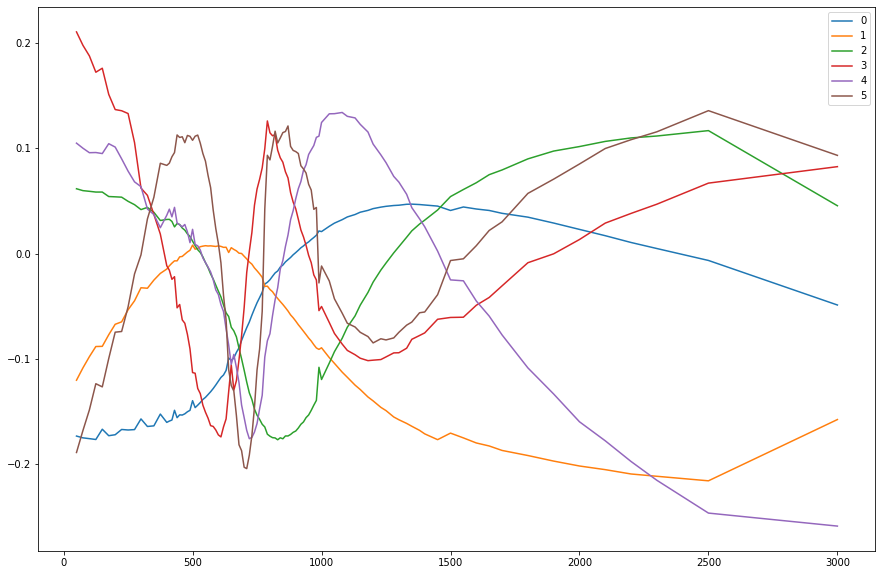

In [8]:
cen = np.array([np.average(x) for x in data.T])

ti_seq = np.array([*list(range(50, 400, 25)),
          *list(range(400, 1000, 10)),
          1000, 1030, 1050, 1080, 1100, 1130, 1150, 1180, 1200, 1230, 1250, 1280, 1300, 1330, 1350, 1380,
          1400, 1450, 1500, 1550, 1600, 1650, 1700,
          1800, 1900, 2000, 2100, 2200, 2300, 2500, 3000])

plt.figure(figsize=(15, 10))
for i in range(6):
    plt.plot(ti_seq, e_vec[:,i], label="{}".format(i))
plt.legend()
plt.show()

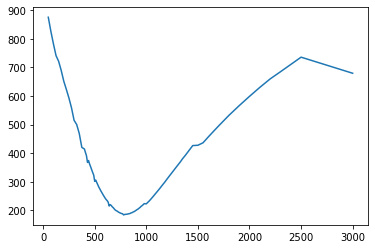

In [9]:
plt.plot(ti_seq, cen)
plt.show()

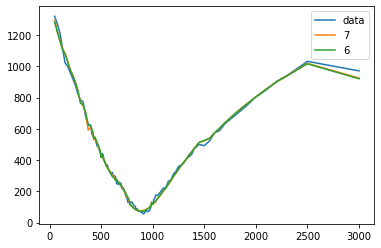

In [10]:
test_data = data[79]
decentr = test_data - cen

vec_count = 7
coefs = []
for i in range(105):
    l = np.linalg.norm(e_vec[:,i])
    coefs.append(sum(decentr * e_vec[:,i]) / (l ** 2))

rec = np.copy(cen)
for i in range(vec_count):
    rec += coefs[i] * e_vec[:,i]

s = np.copy(cen)
for i in range(6):
    s += coefs[i] * e_vec[:,i]

plt.plot(ti_seq, test_data, label="data")
plt.plot(ti_seq, rec, label="7")
plt.plot(ti_seq, s, label="6")
plt.legend()
plt.show()

# Projekcia teoretických kriviek, rôzne varianty výpočtu chyby podľa T1

In [11]:
def model(TI,T1,M0=1.):
    return M0*np.abs(1.-2.*np.exp(-TI/T1))

def model_curve(T1,M0=1.):
    return model(ti_seq,T1,M0)

def curve_coord(curve,base):
    coord = np.dot(base.T,curve)
    bnorm = np.linalg.norm(base,axis=0)
    coord /= bnorm**2
    return coord

def curve_proj(curve,base):
    coord = curve_coord(curve,base)
    proj = np.sum(base * coord,axis=1) 
    return coord,proj

def curve_res(curve,base):
    _,proj = curve_proj(curve,base)
    return np.linalg.norm(curve-proj)

def fit_multigaus(xs, data):
    init_guess = [1, 600, 50,
                  1, 700, 50,
                  1, 850, 50,
                  1, 1000, 50,
                  1, 1200, 50,
                  1, 1350, 50,
                  1, 1600, 50]
    fit, cov = curve_fit(multigauss,
                         xs,
                         data,
                         p0=init_guess,
                         ftol=.001,
                         maxfev=5000)


    height = np.array(fit[0::3])
    center = np.array(fit[1::3])
    width = np.array(fit[2::3])
    cenetr = np.sort(center)
    print(center)

    plt.plot(xs, 1 - data, color='b')
    for t1 in center:
        plt.axvline(x=t1, color='r', label=f"{int(t1)}")
    plt.xlabel("T1")
    plt.legend()
    plt.savefig("gaus_vals_lin")
    plt.show()

    return center

In [12]:
# kolko rozmerov podpriestoru nas zaujima

components = 7
base = e_vec[:,:components]


## Metoda 1

Z grafov chyby pre zafixované intenzity M0 v závislosti od T1
relaxačného času spočítame priemernú chybu v závislosti od T1
relaxačného času.

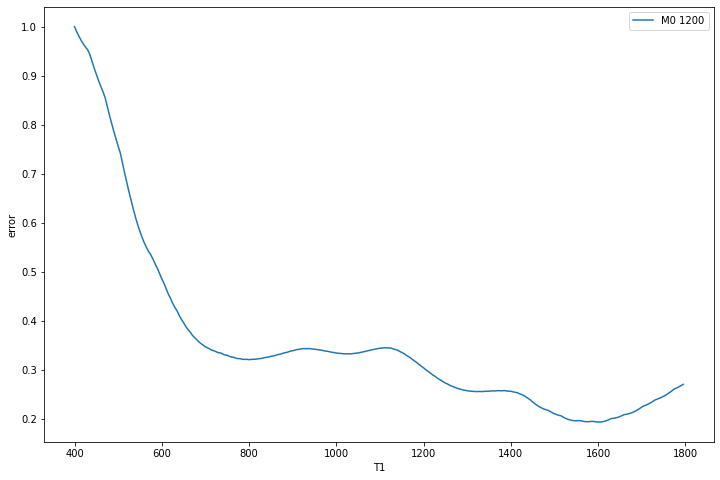

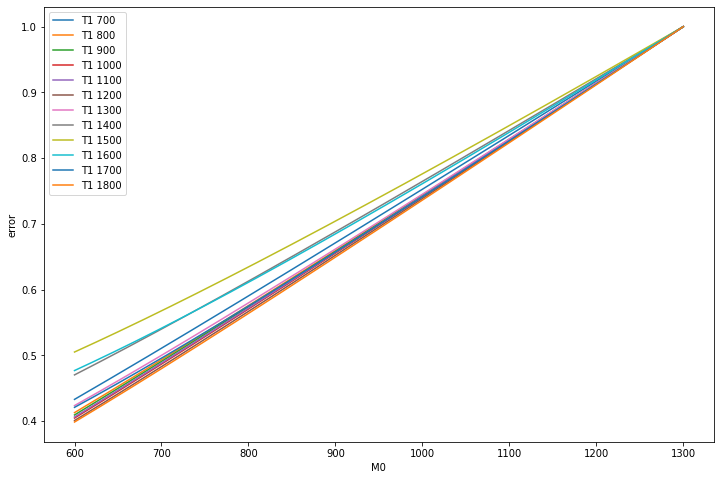

In [13]:
T1_range = list(range(400, 1800, 5))
M0_range = [1200]

errors = []
plt.figure(figsize=(12,8))
for M0 in M0_range:
    res = []
    for T1 in T1_range:
        t1_curve = model_curve(T1,M0)
        t1_cen = t1_curve - cen
        res.append(curve_res(t1_cen,base))
    errors.append(res)
    res = np.array(res)
    plt.plot(T1_range, res / np.max(res), label=f"M0 {M0}")

plt.xlabel("T1")
plt.ylabel("error")
plt.legend()
plt.show()

plt.figure(figsize=(12,8))
for T1 in range(700, 1801, 100):
    res = []
    for M0 in range(600, 1301, 5):
        t1_curve = model_curve(T1,M0)
        t1_cen = t1_curve - cen
        res.append(curve_res(t1_cen,base))
    res = np.array(res)
    plt.plot(range(600, 1301, 5), res / np.max(res), label=f"T1 {T1}")

plt.xlabel("M0")
plt.ylabel("error")
plt.legend()
plt.show()

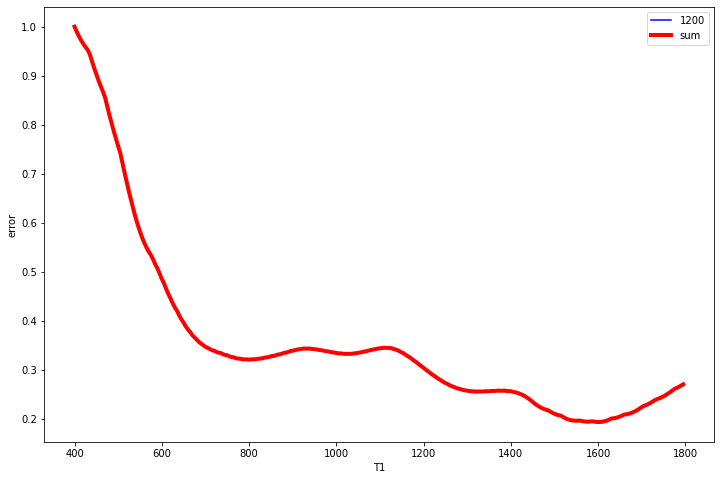

In [14]:
errors = np.array(errors)
errors_norm = np.array([x / np.max(x) for x in errors])

plt.figure(figsize=(12, 8))
for i in range(errors.shape[0]):
    plt.plot(T1_range, errors_norm[i], label=f"{M0_range[i]}", color='b')

avg_array = np.sum(errors_norm / errors_norm.shape[0], axis=0)
plt.plot(T1_range, avg_array, label="sum", color='r', linewidth=4)
plt.xlabel("T1")
plt.ylabel("error")
plt.legend()
plt.show()



[ 533.64556526  637.57923085  782.70014234 1005.70037224 1241.36283563
 1331.02808446 1592.77862123]


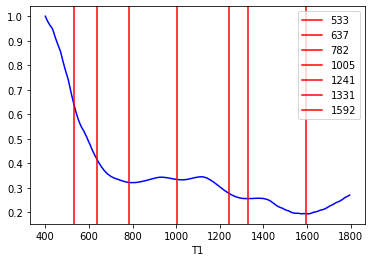

In [15]:
t1s_m1 = fit_multigaus(T1_range, 1 - avg_array)

## Metoda 2

Namiesto toho, aby sme spočítali výslednú chybu ako priemer chýb.
Aplikácia lineárnej algebry zo zafixovaných intenzít M0 v závislosti
od T1 relaxačného času, budeme chybu počítať len z jednej hodnoty
intenzity M0.

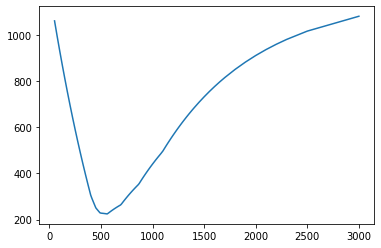

In [16]:
T1_start = np.array([580,650,710,810,1000,1250,1580])

models = []
#for t1 in range(500,1900,200):
for t1 in T1_start:
    models.append(model_curve(t1,1200))

models = np.array(models).T
avgm = np.average(models,axis=1)

plt.plot(ti_seq,avgm)
plt.show()

857.1130074631242


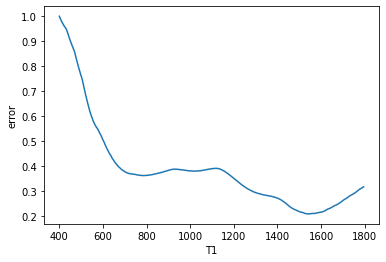

In [17]:
M0 = 1200 * curve_coord(cen,avgm)
print(M0)

c = np.array(list(map(lambda T1: curve_res(model_curve(T1, M0), base), T1_range)))
plt.plot(T1_range, c / c.max())
plt.xlabel("T1")
plt.ylabel("error")
plt.show()

[ 533.98360542  639.20289234  782.30616019 1002.61070544 1230.46756627
 1314.04850914 1563.10470536]


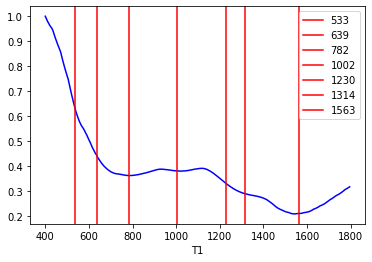

In [18]:
t1s_m2 = fit_multigaus(T1_range, 1 - c / c.max())

## Metoda 3

Pre každý T1 relaxačný čas odvodíme konkrétnu hodnotu intenzity M0.

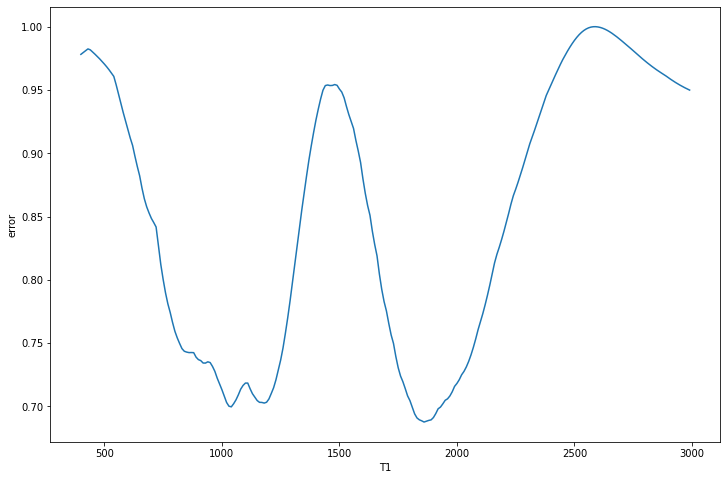

In [19]:
plt.figure(figsize=(12,8))

T1_range = list(range(400,3000,10))

mins = [
    opt.brent(lambda M0: curve_res(model_curve(T1,M0)-cen,base),brack=(0,1000))
    for T1 in T1_range
]
errors = np.array(list(map(lambda TM: curve_res(model_curve(*TM)-cen,base),zip(T1_range,mins))))
plt.plot(T1_range,errors / errors.max(),label='mindist')
# plt.plot(T1range,np.array(mins) / 5,label='M0 / 5')
plt.xlabel("T1")
plt.ylabel("error")
plt.show()

[ 772.49790382  785.46402081  880.59898306 1044.54416033 1204.89562222
 1323.31758177 1916.71100053]


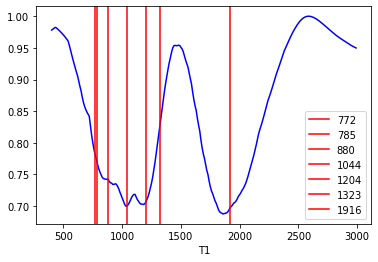

array([ 772.49790382,  785.46402081,  880.59898306, 1044.54416033,
       1204.89562222, 1323.31758177, 1916.71100053])

In [20]:
fit_multigaus(T1_range, 1 - errors / errors.max())

# Hodnoty T1 minimalizující chybu

In [21]:
# T1 urcene prvou metodou
fitt1 = t1s_m1

# Teoretické křivky vrstev, jejich projekce a báze pro skládání

In [22]:
# projekcia povodneho pociatku suradnicovaho systemu do lowdim

low0, high0 = curve_proj(0-cen, base)

# kontrola, ze je to ono (maju vyjst nuly)
base @ low0 - high0

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [23]:
M0 = 800
#  krivka tychto casov, projekcia do lowdim a posun a povodny pociatok
lowt1s = (np.array(
    list(map(
        lambda c: curve_coord(c-cen,base),
        map(lambda ti: model_curve(ti,M0),fitt1)
    ))
) - low0).T

# totéž, ale ve všech dimenzích
hight1s = (np.array(
    list(map(
        lambda c: curve_proj(c-cen,base)[1],
        map(lambda ti: model_curve(ti,M0),fitt1)
    ))
) - high0).T

In [24]:
# je to použitelna baza (10000 je OK)?
np.linalg.cond(lowt1s)

357.9298426405894

In [25]:
# kontrola, malo by to byt rovnake
np.linalg.cond(hight1s)

357.92984264058924

In [ ]:
# krivky najlepsie zodpovejuce jendotlivym vrstvam
# plt.figure(figsize=(12,8))

for i in range(components):
    plt.plot(ti_seq,hight1s[:,i],label=f"v_{str(i)}")
    
plt.legend()
plt.xlabel("TI")
plt.ylabel("M(TI)")
plt.savefig("a")
plt.show()

In [ ]:
plt.plot(ti_seq,hight1s[:,1],label=f"v_{str(i)} (707)", color='r')
for i in range(5, 15, 2):
    plt.plot(ti_seq, model_curve(100 * i, 800), label=f"T1={i*100}", color='b', linewidth=0.5)
plt.legend()
plt.xlabel("TI")
plt.ylabel("M(TI)")
plt.savefig("b")
plt.show()

# Projekcia voxelov, napočítanie M0s

In [27]:
sample = np.random.choice(data.shape[0],5)
sample

array([ 44815,  58933,  93946, 180629,  71346])

44815 [-0.46   0.887 -0.453  1.431 -5.666  6.462 -1.256]
58933 [ 0.686 -1.093  0.735  0.005  4.305 -4.124  0.951]
93946 [-0.058  0.017  0.239  1.002 -4.982  5.566 -1.016]
180629 [ 0.265 -0.071  0.711 -0.113  0.273 -0.274  0.044]
71346 [ 0.261 -0.448  0.295 -0.845  5.888 -5.037  1.191]


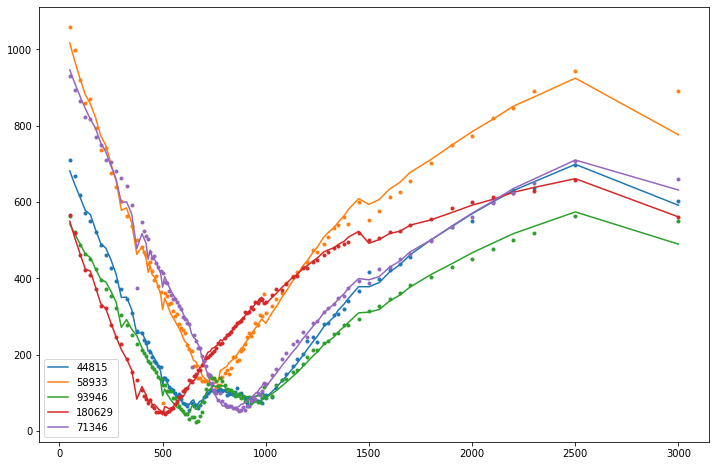

In [28]:
# Takto by to malo ist, no vychadzaju zaporne koeficienty

plt.figure(figsize=(12,8))
for i,idx in enumerate(sample):
    lowc = curve_coord(data[idx]-cen,base)
    M0s = np.linalg.solve(lowt1s,lowc-low0)
    M0s = np.round(M0s,3)
    
    print(idx,M0s)
    highc = hight1s @ M0s
    plt.plot(ti_seq,highc,label=str(idx),color=colors[i])
    plt.plot(ti_seq,data[idx],marker='.',color=colors[i],ls='')
    
plt.legend()
plt.show()

44815 [0.    0.    0.136 0.433 0.147 0.211 0.   ]
58933 [0.156 0.    0.    0.757 0.374 0.    0.194]
93946 [0.    0.    0.211 0.246 0.    0.303 0.   ]
180629 [0.171 0.154 0.514 0.    0.    0.    0.   ]
71346 [0.023 0.    0.    0.    1.018 0.    0.275]


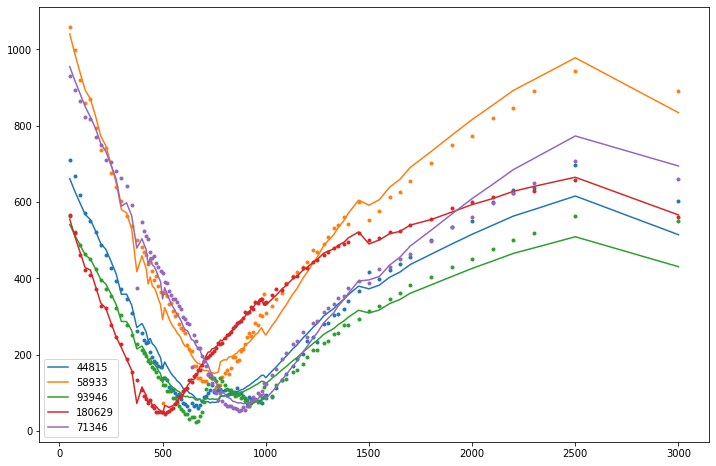

In [29]:
# Zakazeme zaporne koeficienty a je to tam

plt.figure(figsize=(12,8))

for i,idx in enumerate(sample):
    lowc = curve_coord(data[idx]-cen,base)
    
    M0s = opt.lsq_linear(lowt1s,lowc-low0,bounds=(0,np.inf))['x']
    M0s = np.round(M0s,3)

    print(idx,M0s)
    highc = hight1s @ M0s
    plt.plot(ti_seq,highc,label=str(idx),color=colors[i])
    plt.plot(ti_seq,data[idx],marker='.',color=colors[i],ls='')
    
plt.legend()
plt.show()

44815 [0.    0.    0.136 0.433 0.147 0.211 0.   ]
44816 [0.    0.    0.174 0.    0.    0.346 0.552]
44817 [0.    0.    0.    0.    0.    0.742 0.608]
44818 [0.    0.    0.    0.468 0.132 0.    0.768]
44819 [0.3   0.    0.172 0.398 0.    0.    0.073]
44820 [0.    0.492 0.316 0.    0.    0.    0.   ]
44821 [0.067 0.338 0.301 0.107 0.    0.    0.   ]
44822 [0.146 0.    0.656 0.007 0.    0.    0.   ]
44823 [0.123 0.027 0.623 0.028 0.    0.    0.   ]
44824 [0.091 0.063 0.587 0.016 0.    0.    0.   ]


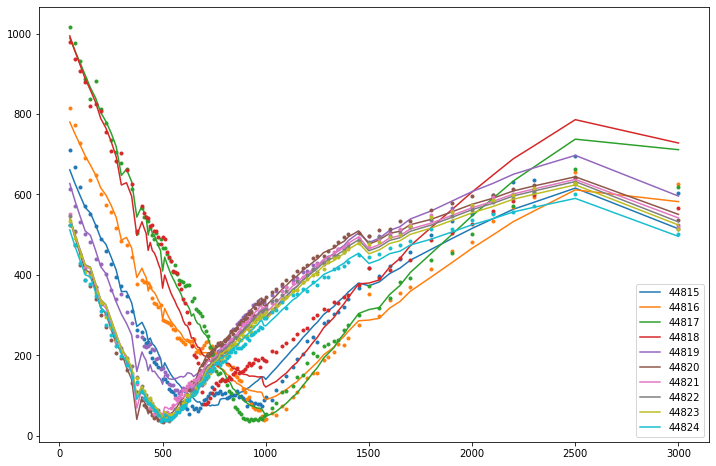

In [30]:
# 10 susednych voxelov, malo by vychadzat rouzumne spojite

plt.figure(figsize=(12,8))

idx = sample[0]
for i in range(10):
    lowc = curve_coord(data[idx+i]-cen,base)
     
    M0s = opt.lsq_linear(lowt1s,lowc-low0,bounds=(0,np.inf))['x']
    M0s = np.round(M0s,3)

    print(idx+i,M0s)
        
    highc = hight1s @ M0s
    plt.plot(ti_seq,highc,label=str(idx+i),color=colors[i])
    plt.plot(ti_seq,data[idx+i],marker='.',color=colors[i],ls='')
    
plt.legend()
plt.show()

# Vizualizácia koeficientov a dominantných T1 v rezoch

Napocitanie koeficientov trva priblizne 10 min.

In [ ]:
import nibabel as nib

data = np.load("data/BigBrain/syn_signal.npy")
print(data.shape)

brain_m0s = []
for i, slice in enumerate(data):
    slice = slice.reshape((57 * 65, 105))
    for voxel in slice:
        lowc = curve_coord(voxel-cen, base)

        M0s = opt.lsq_linear(lowt1s, lowc-low0, bounds=(0,np.inf))['x']
        M0s = np.round(M0s, 3)
        brain_m0s.append(M0s)
    print(f"{i + 1}/{data.shape[0]}")

np.save("data/t1_vec_coefs_syn_7", np.array(brain_m0s))

(74, 57, 65, 105)
1/
2/
3/
4/
5/
6/
7/
8/
9/
10/
11/
12/
13/
14/
15/
16/
17/
18/
19/
20/
21/
22/
23/
24/
25/
26/


## Vizualizácia dominantného komponentu

In [ ]:
from back_to_voxels import choose_dominant_class

brain_m0s = np.load("data/t1_vec_coefs_syn_7.npy")

print(brain_m0s.shape)
dom_classes = choose_dominant_class(brain_m0s)
reshaped = np.reshape(dom_classes, (74, 57, 65)).transpose((1, 0, 2))

palette = np.array([[0xFF, 0xFF, 0XFF],
                    [0x12, 0x4E, 0X78],
                    [0x12, 0x66, 0X4E],
                    [0xF0, 0xF0, 0XC9],
                    [0xF2, 0xBB, 0X05],
                    [0xD7, 0x4E, 0X09],
                    [0x6E, 0x0E, 0X0A]])

for i in range(len(reshaped)):
    rgb = palette[reshaped[i] + 1]
    plt.imshow(rgb)
    plt.title("Dominant class " +
                " slice " + str(i + 1))
    plt.savefig(f"dom_syn_data_{i}")
    plt.show()

In [ ]:
from back_to_voxels import choose_dominant_class
syn_data = np.load("data/BigBrain/all.npy")
print(syn_data.shape)
dom_classes = np.array(choose_dominant_class(syn_data.reshape((74 * 57 * 65, 8)))) - 1
reshaped = np.reshape(dom_classes, (74, 57, 65)).transpose((1, 0, 2))

palette = np.array([[0xFF, 0xFF, 0XFF],
                    [0x12, 0x4E, 0X78],   # L1
                    [0x12, 0x66, 0X4E],   # L2
                    [0xF2, 0xBB, 0X05],   # L4
                    [0xF0, 0xF0, 0XC9],   # L3
                    [0x6E, 0x0E, 0X0A],   # L6
                    [0xD7, 0x4E, 0X09],   # L5
                    [0xF0, 0xF0, 0XF0]])  # WM
#
# for i in range(len(reshaped)):
#     rgb = palette[reshaped[i] + 1]
#     plt.imshow(rgb)
#     plt.title("Dominant class " +
#                 " slice " + str(i + 1))
#     plt.savefig(f"dom_syn_m1_{i}")
#     plt.show()
clss = 2

classes = syn_data.transpose((3, 0, 1, 2))
for i in range(8):
    classes[i] /= np.max(classes[i])

for i in range(len(classes[clss])):
    plt.imshow(classes[clss][i].astype(float), vmin=0, vmax=1)
    plt.colorbar()
    plt.title("Intensity of class " + str(clss) +
                " slice " + str(i + 1))

    plt.savefig(f"plot-{clss}-{i}")
    plt.show()


## Vizualizácia inteznzit

In [ ]:
brain_m0s = np.load("data/t1_vec_coefs_syn.npy")

classes = np.reshape(brain_m0s, (74, 57, 65, 6)).transpose((3, 1, 0, 2))


for i in range(6):
    classes[i] /= np.max(classes[i])

In [ ]:
clss = 1

for i in range(len(classes[clss])):
    plt.imshow(classes[clss][i].astype(float), vmin=0, vmax=1)
    plt.colorbar()
    plt.title("Intensity of class " + str(clss) +
                " slice " + str(i + 1))

    plt.savefig(f"plot-{clss}-{i}")
    plt.show()


